In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150
pd.options.mode.chained_assignment = None  # default='warn'

#### Importation des CSV fournis par olist

In [3]:
df_olist_customers_dataset = pd.read_csv("data/olist_customers_dataset.csv")
df_olist_order_items_dataset = pd.read_csv("data/olist_order_items_dataset.csv")
df_olist_order_payments_dataset = pd.read_csv("data/olist_order_payments_dataset.csv")
df_olist_order_reviews_dataset = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_olist_orders_dataset = pd.read_csv("data/olist_orders_dataset.csv")
df_olist_products_dataset = pd.read_csv("data/olist_products_dataset.csv")
df_olist_sellers_dataset = pd.read_csv("data/olist_sellers_dataset.csv")
df_product_category_name_translation = pd.read_csv("data/product_category_name_translation.csv")
df_olist_geolocation_dataset = pd.read_csv("data/olist_geolocation_dataset.csv")

#### Transformation des colonnes review_comment_title et review_comment_message pour obtenir les longueurs du message et du titre

In [4]:
from functions import *

df_olist_order_reviews_dataset['length_comment_title'] = df_olist_order_reviews_dataset["review_comment_title"].apply(lambda x:length_str(x))
df_olist_order_reviews_dataset['length_comment_message'] = df_olist_order_reviews_dataset["review_comment_message"].apply(lambda x:length_str(x))

df_olist_order_reviews_dataset.drop(["review_comment_title","review_comment_message"],axis=1,inplace=True)

df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.groupby(["order_id","review_score"]).agg({"length_comment_title":"max","length_comment_message":"max","review_answer_timestamp":"first"})
df_olist_order_reviews_dataset.reset_index(inplace=True)

#### Conversion de la colonne 'date' en un objet de type datetime

In [5]:
df_olist_order_reviews_dataset['review_answer_timestamp'] = pd.to_datetime(df_olist_order_reviews_dataset['review_answer_timestamp'])

#### Regroupement par order_id et recherche de l'index de la date la plus récente

In [6]:
latest_dates = df_olist_order_reviews_dataset.groupby('order_id').review_answer_timestamp.idxmax()

#### Utilisation de l'index trouvé pour sélectionner les lignes avec les dates les plus récentes

In [7]:
df_olist_order_reviews_dataset = df_olist_order_reviews_dataset.loc[latest_dates]

Remplacement de valeurs manquantes dans le dataset products :
- NaN de la colonne product_photos_qty => 0
- NaN de la colonne product_category_name => "unknown"
- NaN de la colonne product_description_lenght => 0

Suppression de la colonne product_name_lenght.

In [8]:
df_olist_products_dataset["product_photos_qty"].fillna(0,inplace=True)
df_olist_products_dataset["product_photos_qty"] = df_olist_products_dataset["product_photos_qty"].astype('int8')
df_olist_products_dataset["product_category_name"].fillna("unknown",inplace=True)
df_olist_products_dataset["product_description_lenght"].fillna(0,inplace=True)
df_olist_products_dataset.drop("product_name_lenght",axis=1,inplace=True)

On remplace les noms de catégories initialement en Portugais par leur correspondance en Anglais.

In [9]:
df_product = df_olist_products_dataset.merge(df_product_category_name_translation,how="outer",on="product_category_name")
df_product["product_category_name_english"].fillna("unknown",inplace=True)
df_product.drop("product_category_name",axis=1,inplace=True)

Calcul du montant total vendu pour chaque categorie

In [10]:
df_categorie = df_olist_orders_dataset.merge(df_olist_order_payments_dataset,how="outer",on="order_id")
df_categorie = df_categorie.merge(df_olist_order_items_dataset,how="outer",on="order_id")
df_categorie = df_categorie.merge(df_product,how="outer",on='product_id')
df_categorie = df_categorie.loc[df_categorie['order_status'] == "delivered"]
df_categorie = df_categorie.groupby("product_category_name_english").agg({"price":"sum","freight_value":"sum","order_item_id":"count"}).reset_index()
df_categorie["montant_total"] = df_categorie["price"] + df_categorie["freight_value"]

#### Liste de catégories initiale
Affichage des montants totaux et nombres de produits vendus par catégorie

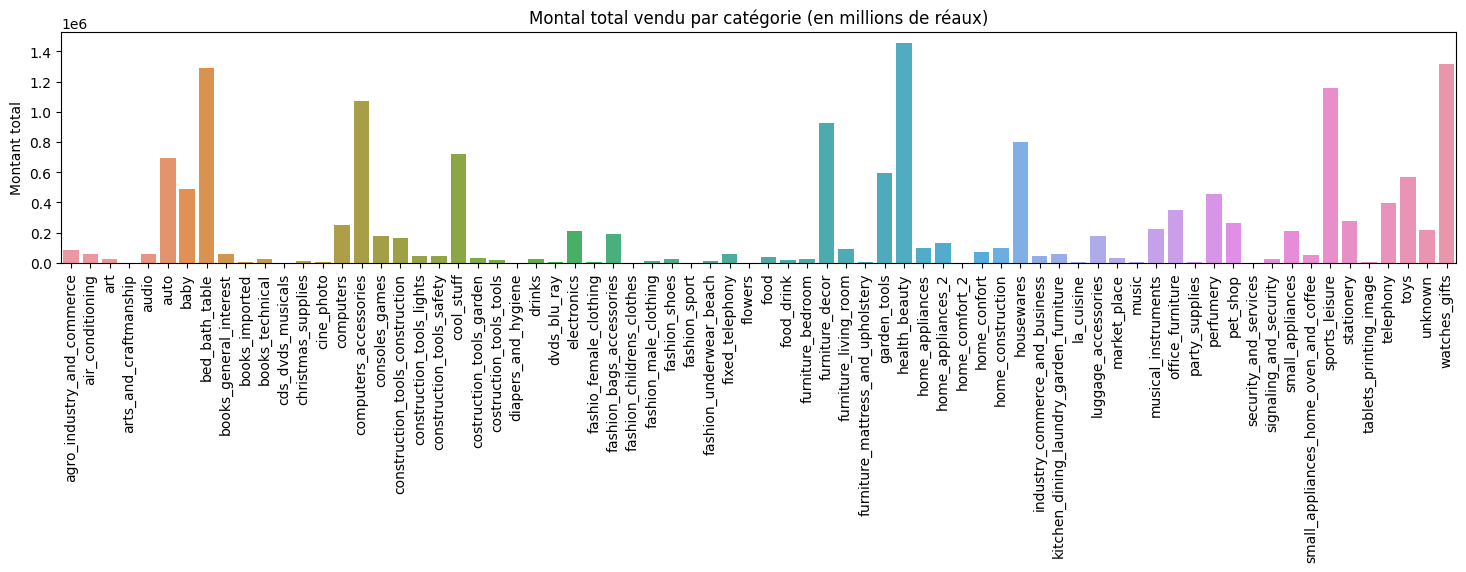

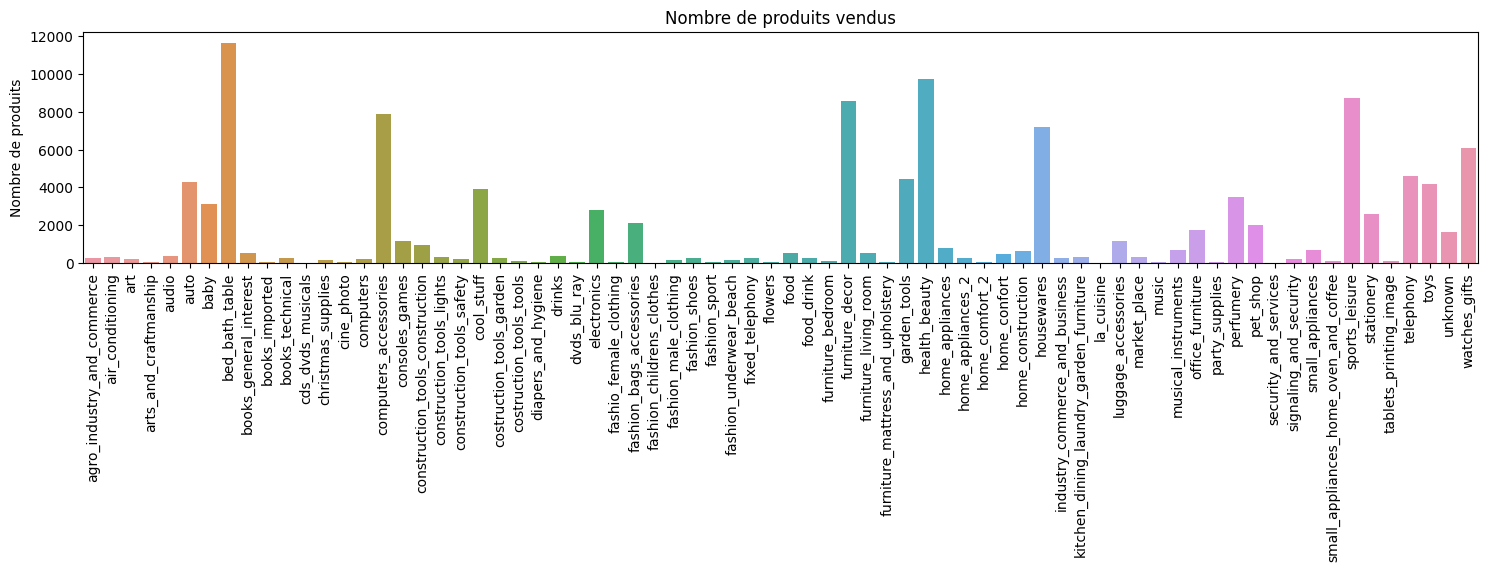

In [11]:
fig, ax = plt.subplots(figsize=(18, 3))

# Premier histogramme
sns.barplot(data = df_categorie , x="product_category_name_english",y="montant_total",ax=ax)
ax.set_title(f"Montal total vendu par catégorie (en millions de réaux)")
ax.set_xlabel("")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=90, ha='center')
ax.set_ylabel("Montant total")

plt.show()

fig, ax = plt.subplots(figsize=(18, 3))

# Affichage de la figure
sns.barplot(data = df_categorie , x="product_category_name_english",y="order_item_id",ax=ax)
ax.set_title(f"Nombre de produits vendus")
ax.set_xlabel("")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=90, ha='center')
ax.set_ylabel("Nombre de produits")

plt.show()

#### Création d'une nouvelle liste de catégories à des fins d'analyse

On part des ~70 catégories initiales et on les regroupe dans une quinzaine de nouvelles catégories plus compréhensibles et interprétables

In [12]:
category_mapping = {
"Agro_Industry_and_Commerce": ["agro_industry_and_commerce", "industry_commerce_and_business"],
"Home_and_Comfort": ["air_conditioning", "home_appliances", "home_appliances_2", "home_comfort_2", "home_confort", "housewares", "la_cuisine", "small_appliances", "small_appliances_home_oven_and_coffee","security_and_services", "signaling_and_security"],
"Audio_and_Visual": ["audio", "cds_dvds_musicals", "cine_photo", "dvds_blu_ray", "music", "musical_instruments", "tablets_printing_image"],
"Automotive": ["auto"],
"Baby": ["baby", "diapers_and_hygiene"],
"Food_and_drinks": ["drinks", "food", "food_drink"],
"Computers_and_Electonics": ["computers", "computers_accessories", "electronics"],
"Construction": ["construction_tools_construction", "construction_tools_lights", "construction_tools_safety", "costruction_tools_garden", "costruction_tools_tools", "home_construction"],
"Well-being": ["art", "arts_and_craftmanship","flowers", "party_supplies", "toys", "cool_stuff", "christmas_supplies", "pet_shop", "consoles_games", "luggage_accessories", "watches_gifts", "garden_tools", "books_general_interest", "books_imported", "books_technical"],
"Health_and_Beauty": ["health_beauty","perfumery"],
"Fashion": ["fashio_female_clothing", "fashion_bags_accessories", "fashion_childrens_clothes", "fashion_male_clothing", "fashion_shoes", "fashion_underwear_beach"],
"Sport": ["sports_leisure", "fashion_sport"],
"Miscellaneous": ["market_place", "stationery", "unknown"],
"Communication": ["telephony", "fixed_telephony"],
"Furniture": ["bed_bath_table","furniture_decor", "office_furniture","furniture_bedroom", "furniture_living_room", "furniture_mattress_and_upholstery","kitchen_dining_laundry_garden_furniture"]
}

def reverse_dict(d):
    rev_dict = {}
    for key, value in d.items():
        for val in value:
            rev_dict[val] = key
    return rev_dict

reversed_mapping = reverse_dict(category_mapping)

#### Mapping liste de catégories initiale vers nouvelle liste simplifiée

In [13]:
df_categorie["product_category_name_english"] = df_categorie["product_category_name_english"].map(reversed_mapping)
df_categorie = df_categorie.groupby("product_category_name_english").agg({"montant_total":"sum","order_item_id":"sum"}).reset_index()

#### Nouvelle liste de catégories
Affichage des montants totaux et nombres de produits vendus par catégorie

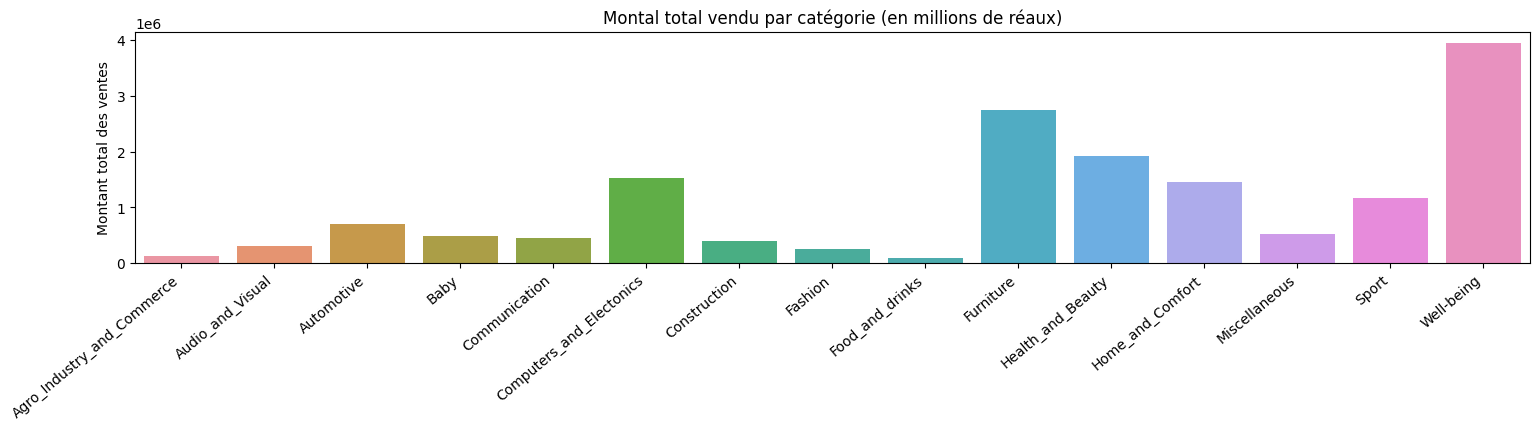

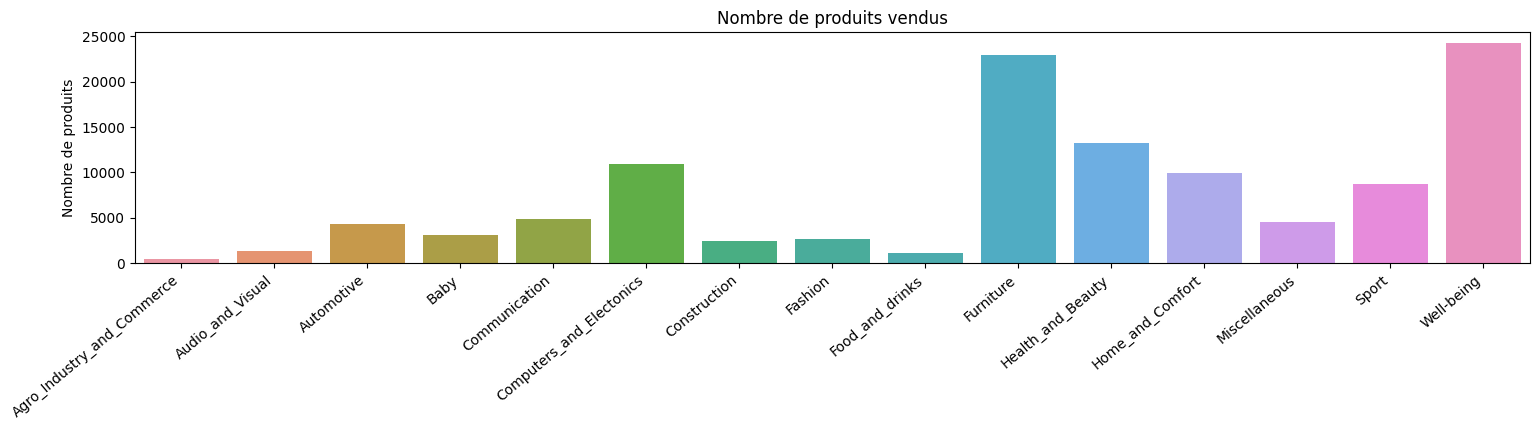

In [15]:
fig, ax = plt.subplots(figsize=(18, 3))

# Premier histogramme
sns.barplot(data = df_categorie , x="product_category_name_english",y="montant_total",ax=ax)
ax.set_title(f"Montal total vendu par catégorie (en millions de réaux)")
ax.set_xlabel("")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=40, ha='right')
ax.set_ylabel("Montant total des ventes")

plt.show()

fig, ax = plt.subplots(figsize=(18, 3))

# Affichage de la figure
sns.barplot(data = df_categorie , x="product_category_name_english",y="order_item_id",ax=ax)
ax.set_title(f"Nombre de produits vendus")
ax.set_xlabel("")
ax.set_xticklabels(df_categorie["product_category_name_english"],rotation=40, ha='right')
ax.set_ylabel("Nombre de produits")

plt.show()

#### Regroupement par la colonne order_id dans le dataset des order_items

L'objectif est d'obtenir :
- le produit et le vendeur les plus fréquents
- le nombre de produits dans la commande
- la somme des prix et coûts de transport

In [113]:
def get_mode(x):
    return x.mode().iloc[0]
    
df_olist_order_items_dataset = df_olist_order_items_dataset.groupby(["order_id"]).agg({"product_id":get_mode,"seller_id":get_mode,"order_item_id":"count","price":"sum","freight_value":"sum"})
df_olist_order_items_dataset.columns=["product_most_frequent","most_frequent_seller",'nb_items', 'sum_price', 'sum_freight_value']
df_olist_order_items_dataset.reset_index(inplace=True)

#### Regroupement par order_id dans le dataset payments pour que les order_id soit uniques

In [114]:
df_olist_order_payments_dataset = df_olist_order_payments_dataset.groupby(["order_id"]).agg({"payment_type":get_mode,"payment_sequential":"count","payment_installments":"max","payment_value":"sum"})
df_olist_order_payments_dataset.rename(columns={"payment_type":"payment_type_most_frequent"},inplace=True)
df_olist_order_payments_dataset.reset_index(inplace=True)

#### Merge final des datasets

In [115]:
df_merge = df_olist_orders_dataset.merge(df_olist_order_reviews_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_order_payments_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_order_items_dataset,how="outer",on="order_id")
df_merge = df_merge.merge(df_olist_customers_dataset,how="outer",on="customer_id")
df_merge = df_merge.merge(df_product,how="left",right_on='product_id',left_on="product_most_frequent")
df_merge = df_merge.merge(df_olist_sellers_dataset,how="left",left_on="most_frequent_seller",right_on="seller_id")

#### Création d'un dataframe Code Postal / Latitude / Longitude à partir du dataframe geolocation
L'objectif est ici de calculer la distance entre le vendeur et le client et d'intégrer cette donnée dans le dataframe de travail

In [116]:
# Group the dataframe by zip code and aggregate by median latitude and median longitude
zip_code_lat_long = df_olist_geolocation_dataset.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat': 'median', 'geolocation_lng': 'median'}).reset_index()

df_merge["seller_zip_code_prefix"].fillna(0,inplace=True)
df_merge["seller_zip_code_prefix"] = df_merge["seller_zip_code_prefix"].astype("int32")

df_merge = df_merge.merge(zip_code_lat_long,how="left",left_on="customer_zip_code_prefix",right_on="geolocation_zip_code_prefix")
df_merge.rename(columns={"geolocation_lat":"customer_geolocation_lat","geolocation_lng":"customer_geolocation_lng"}, inplace=True)
df_merge.drop("geolocation_zip_code_prefix", axis=1,inplace=True)

df_merge = df_merge.merge(zip_code_lat_long,how="left",left_on="seller_zip_code_prefix",right_on="geolocation_zip_code_prefix")
df_merge.rename(columns={"geolocation_lat":"seller_geolocation_lat","geolocation_lng":"seller_geolocation_lng"}, inplace=True)
df_merge.drop("geolocation_zip_code_prefix", axis=1,inplace=True)

df_merge['distance'] = ((df_merge.customer_geolocation_lat - df_merge.seller_geolocation_lat)**2 + (df_merge.customer_geolocation_lng - df_merge.seller_geolocation_lng)**2)**0.5

#### Visualisation des valeurs manquantes dans le dataframe de travail

<AxesSubplot: >

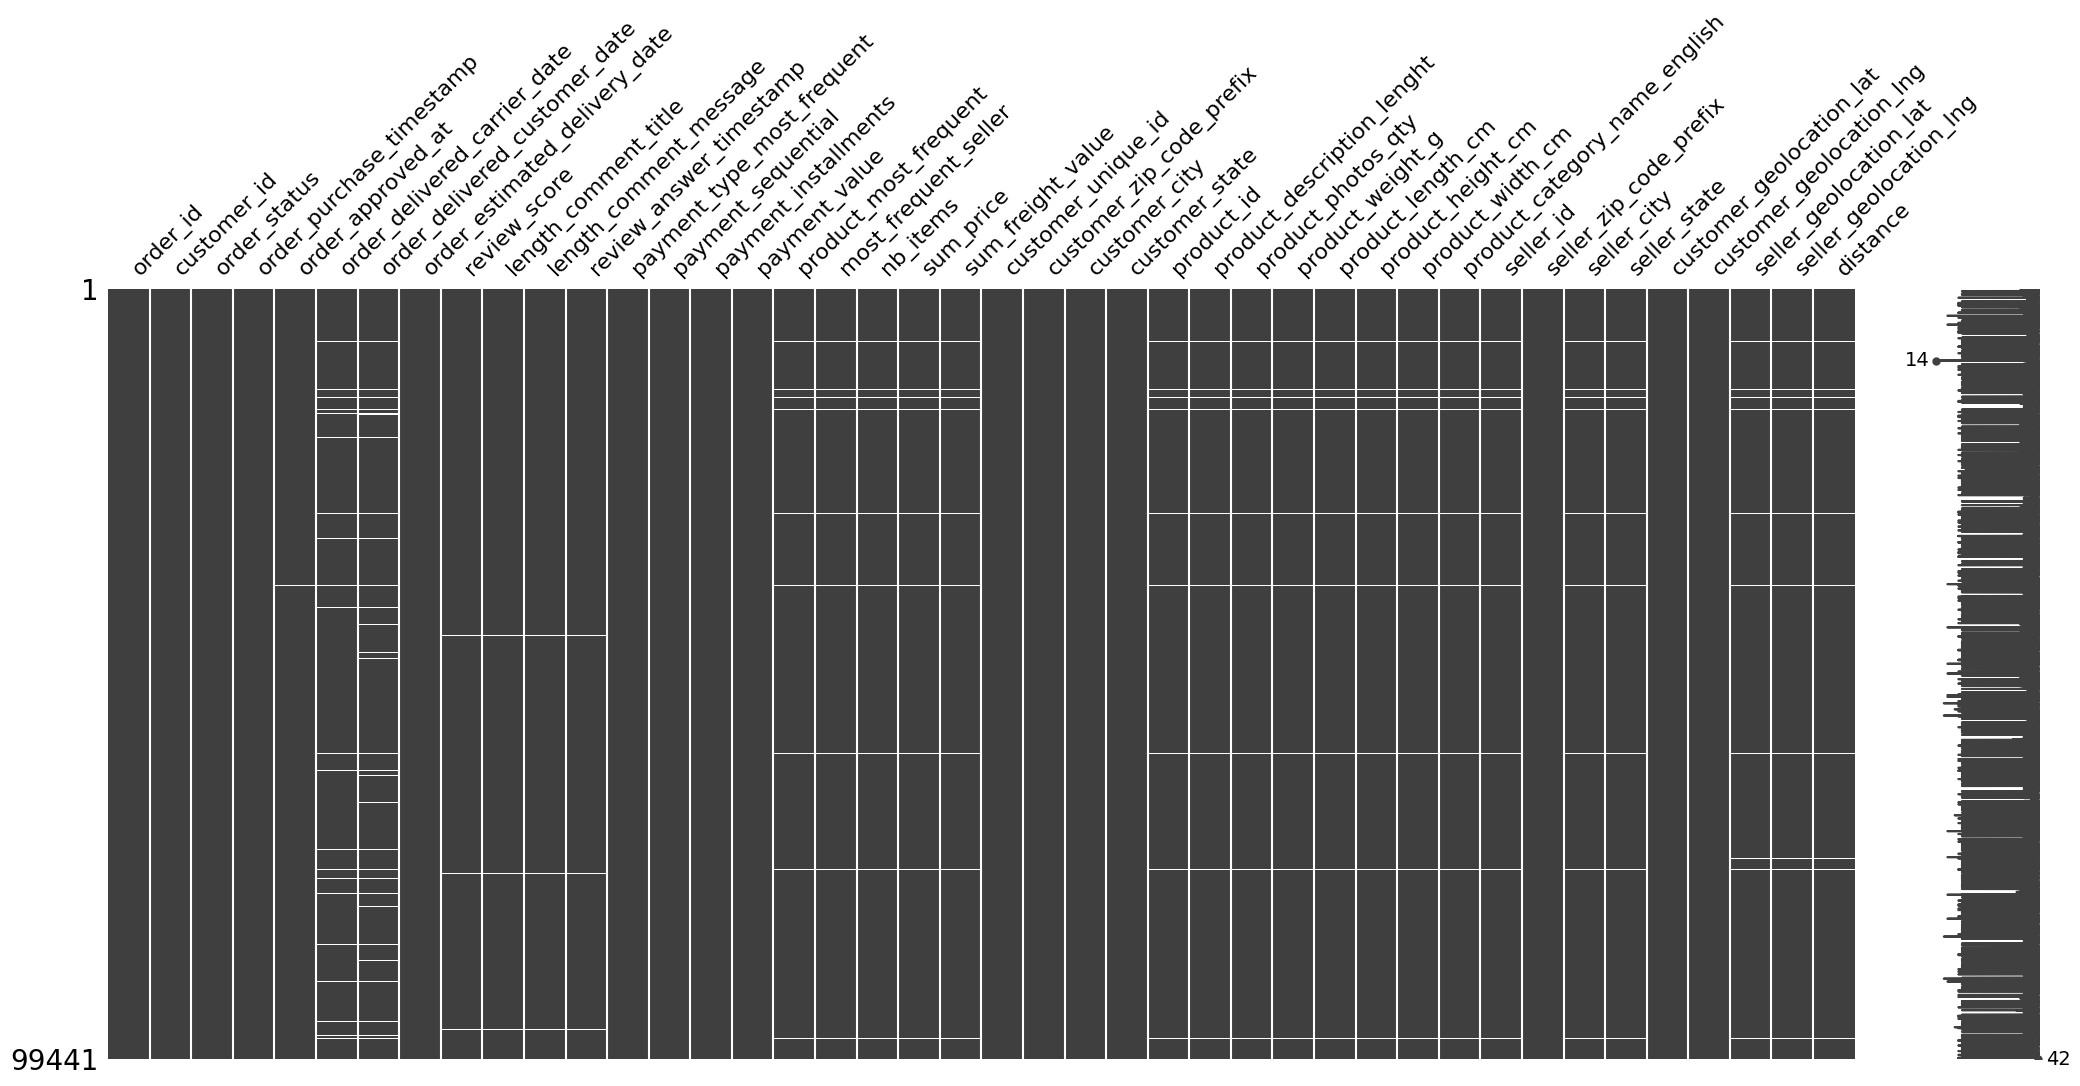

In [117]:
import missingno as msno

msno.matrix(df_merge)

In [118]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  object        
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
 8   review_score                   98673 non-null  float64       
 9   length_comment_title           98673 non-null  float64       
 10  length_comment_message         98673 non-null  float64       
 11  review_answer_t

In [119]:
df_merge.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_score', 'length_comment_title', 'length_comment_message',
       'review_answer_timestamp', 'payment_type_most_frequent',
       'payment_sequential', 'payment_installments', 'payment_value',
       'product_most_frequent', 'most_frequent_seller', 'nb_items',
       'sum_price', 'sum_freight_value', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_id', 'product_description_lenght', 'product_photos_qty',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_category_name_english', 'seller_id',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'customer_geolocation_lat', 'customer_geolocation_lng',
       'seller_geolocation_lat', 'selle

In [120]:
columns=["review_score","length_comment_title","length_comment_message","payment_installments","payment_value","nb_items","product_description_lenght","product_photos_qty"]

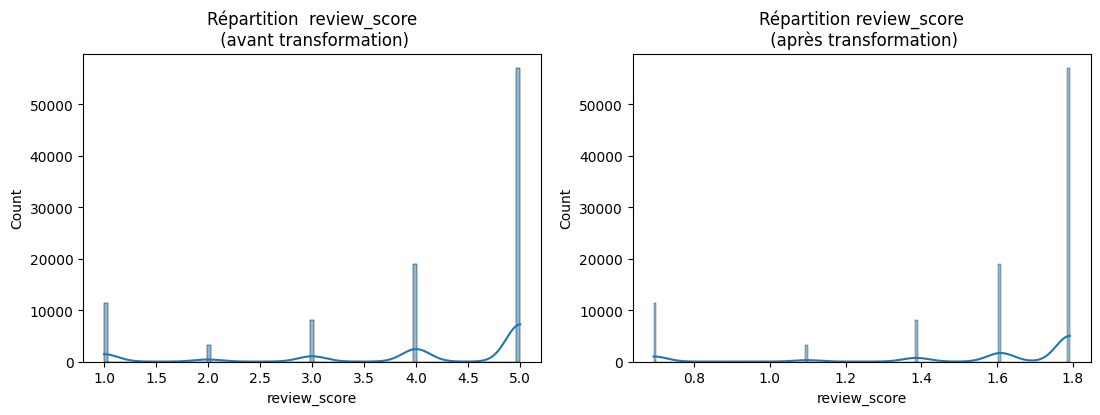

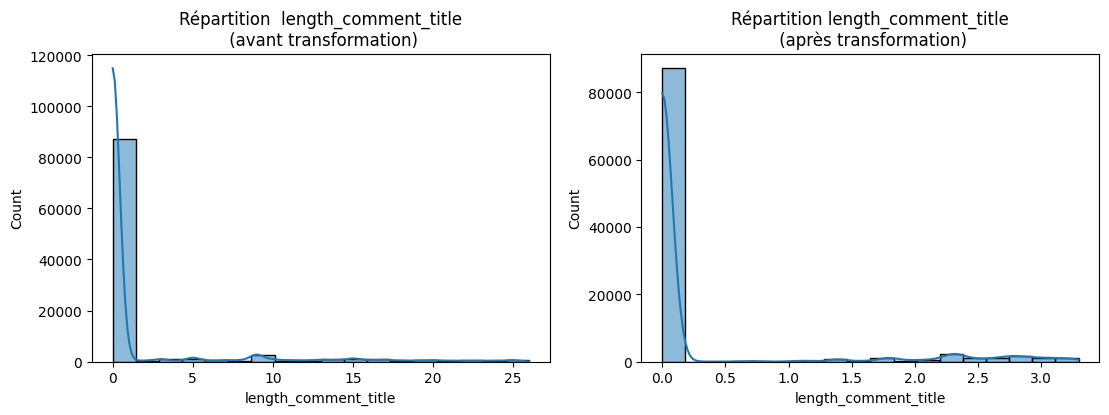

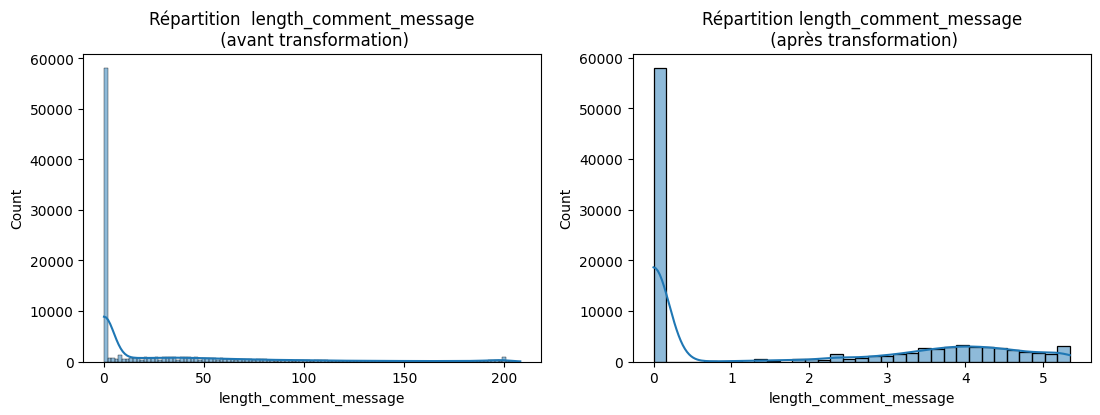

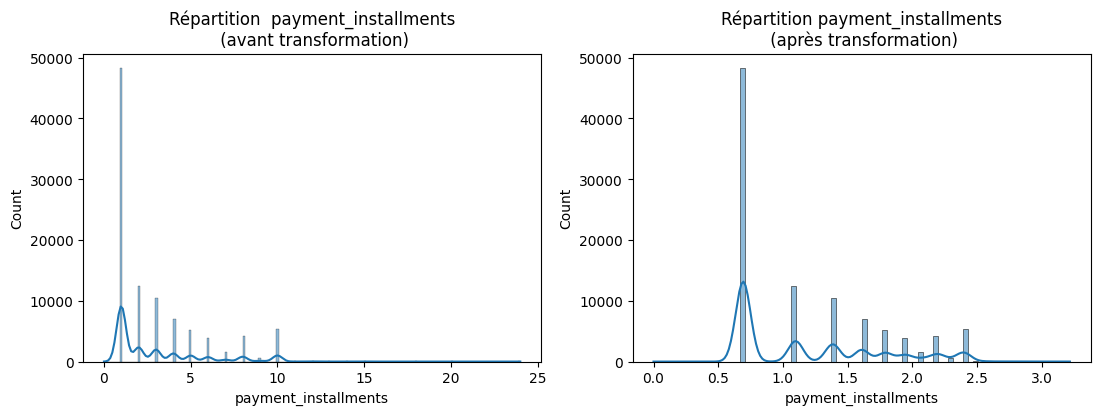

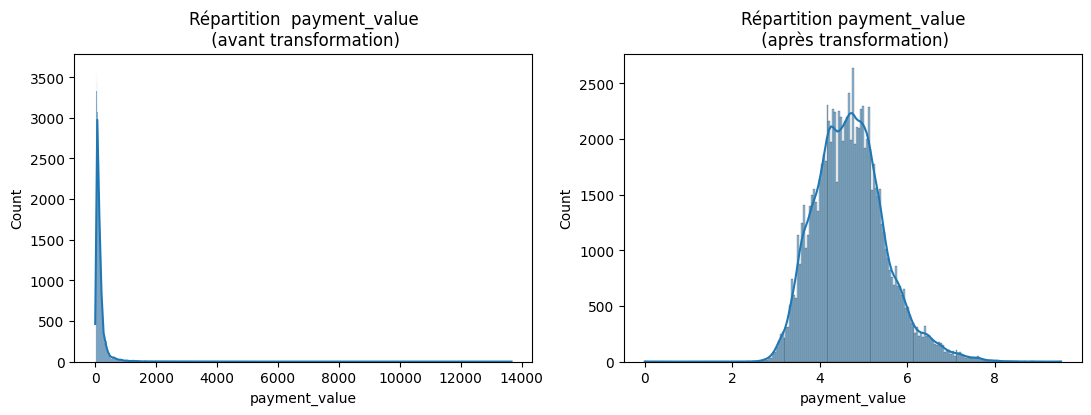

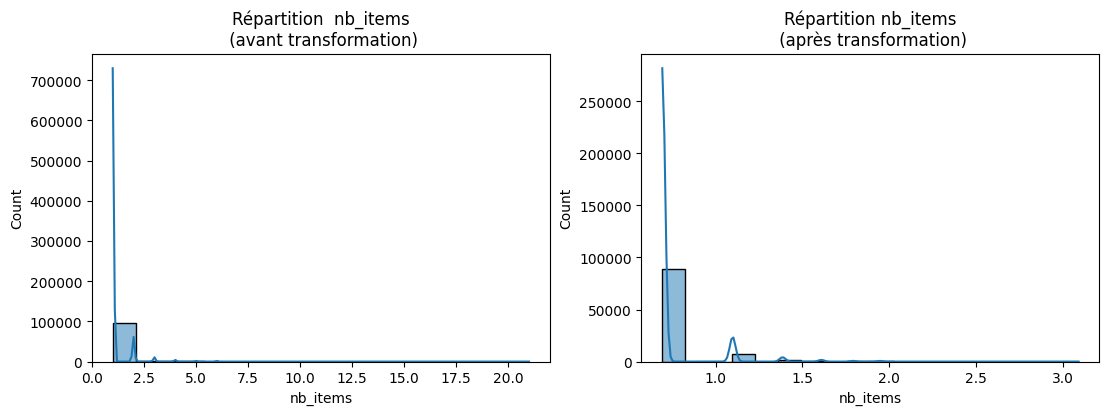

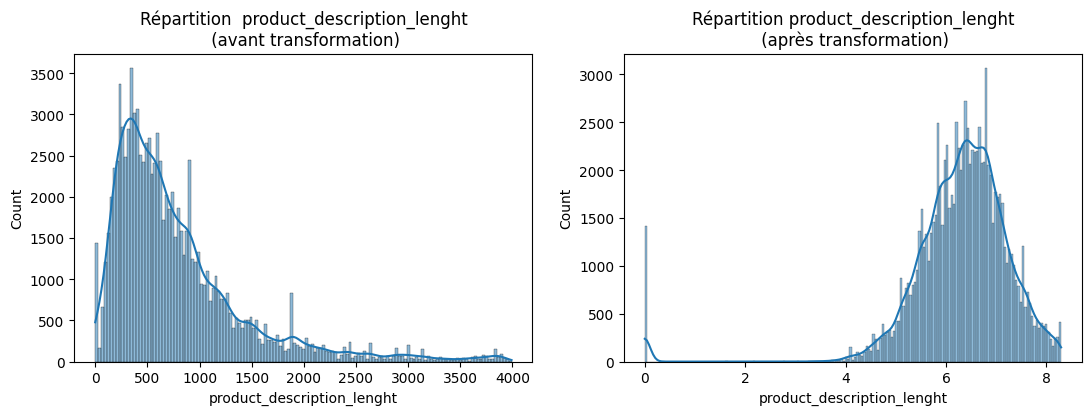

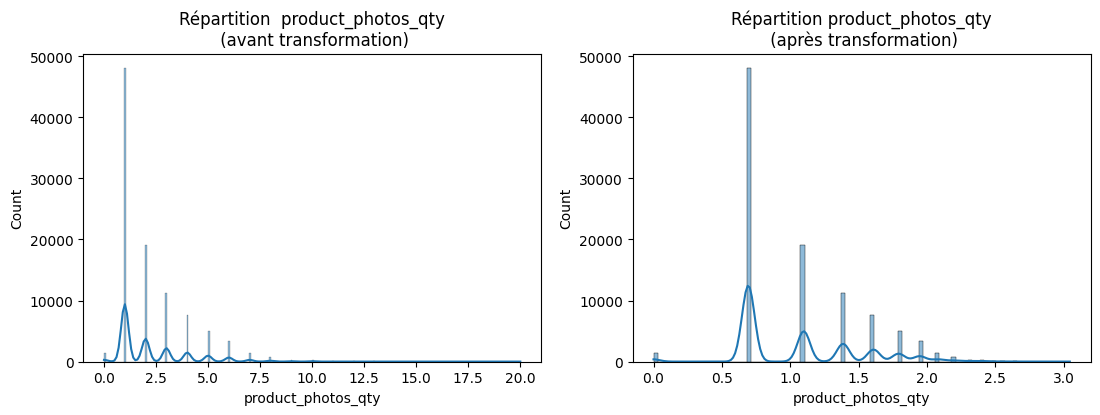

In [121]:
df_log = np.log1p(df_merge[columns])

for col in columns:
    # Création de la figure et des subplots
    fig, ax = plt.subplots(1,2, figsize=(13, 4))

    # Premier histogramme
    sns.histplot(df_merge[col],ax=ax[0], kde=True)
    ax[0].set_title(f"Répartition  {col}\n (avant transformation)")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Count")

    # Second histogramme
    sns.histplot(df_log[col],ax=ax[1], kde=True)
    ax[1].set_title(f"Répartition {col}\n (après transformation)")
    ax[1].set_xlabel(col)
    ax[1].set_ylabel("Count")

    # Affichage de la figure
    plt.show()

In [122]:
df_merge['order_status'].value_counts().to_frame()/len(df_merge)*100

,order_status
delivered,97.020344
shipped,1.113223
canceled,0.628513
unavailable,0.612423
invoiced,0.315765
processing,0.302692
created,0.005028
approved,0.002011


Nous ne conservons que les order_statuts qui sont "delivered" car les autres catégories sont trop peu représentées

In [123]:
df_merge = df_merge.loc[df_merge['order_status'] == "delivered"]

In [124]:
df_merge[df_merge["distance"].isnull()]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,length_comment_title,length_comment_message,review_answer_timestamp,payment_type_most_frequent,payment_sequential,payment_installments,payment_value,product_most_frequent,most_frequent_seller,nb_items,sum_price,sum_freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_id,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_id,seller_zip_code_prefix,seller_city,seller_state,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng,distance
445,690199d6a2c51ff57c6b392d7680cbfd,19bacb562bd43bd4eaf05b6c0a59dad0,delivered,2018-03-16 11:31:18,2018-03-16 11:49:14,2018-03-19 19:56:23,2018-05-14 12:28:56,2018-04-11 00:00:00,5.0,0.0,0.0,2018-04-17 17:23:15,credit_card,1.0,3.0,73.25,75d6b6963340c6063f7f4cfcccfe6a30,cc419e0650a3c5ba77189a1882b7556a,1.0,54.99,18.26,c5f01991eadc43c924dfd891e9026217,87323,alto sao joao,PR,75d6b6963340c6063f7f4cfcccfe6a30,999.0,2.0,400.0,18.0,11.0,20.0,perfumery,cc419e0650a3c5ba77189a1882b7556a,9015,santo andre,SP,NaN,NaN,-23.658690,-46.522495,NaN
610,9f2da077d2d1eb6e8abcacef8776e941,2386792ff4818fe030a3b1364994f51e,delivered,2017-10-28 21:26:26,2017-10-28 21:46:29,2017-11-06 11:08:52,2017-11-13 22:33:12,2017-11-22 00:00:00,5.0,0.0,0.0,2017-11-15 10:42:45,credit_card,1.0,2.0,54.00,5e3555ed62835dd67704d40a72678cfd,bbad7e518d7af88a0897397ffdca1979,1.0,39.90,14.10,ab7bed4092cc3dadbaefba86cb45f37f,73081,brasilia,DF,5e3555ed62835dd67704d40a72678cfd,644.0,1.0,300.0,16.0,16.0,16.0,baby,bbad7e518d7af88a0897397ffdca1979,1512,sao paulo,SP,NaN,NaN,-23.553907,-46.629081,NaN
681,1b00c4d80c81cdbc36487c96c6e92f07,6f392cfb40b84e0857b16c23c773aa31,delivered,2017-05-14 09:36:36,2017-05-16 03:22:50,2017-05-16 12:05:28,2017-05-23 07:52:33,2017-06-02 00:00:00,5.0,0.0,0.0,2017-06-09 21:58:25,boleto,1.0,1.0,112.92,b6c3ac7e88727311d75dc5695fb9f18e,2f09f7d37a97956d11cc1a7cadd5262b,1.0,95.00,17.92,5399c9213ca365a480537a1b21423d2c,28160,santo eduardo,RJ,b6c3ac7e88727311d75dc5695fb9f18e,163.0,3.0,1600.0,30.0,30.0,30.0,sports_leisure,2f09f7d37a97956d11cc1a7cadd5262b,14090,ribeirao preto,SP,NaN,NaN,-21.181012,-47.789520,NaN
771,d445a6e277eaa62900bc18d453d96d76,c2cd065252fa7ad04274d9d69dd9c09e,delivered,2017-08-03 10:39:39,2017-08-03 10:50:24,2017-08-07 14:57:56,2017-08-14 20:37:25,2017-09-06 00:00:00,5.0,0.0,40.0,2017-08-16 12:48:19,credit_card,1.0,5.0,225.42,9afaad66aca8b0c79e4f084a89c9c92b,42bde9fef835393bb8a8849cb6b7f245,1.0,199.00,26.42,e808aa0ce98f33e671bf3e5b47756564,69918,rio branco,AC,9afaad66aca8b0c79e4f084a89c9c92b,965.0,3.0,150.0,20.0,7.0,14.0,telephony,42bde9fef835393bb8a8849cb6b7f245,71551,brasilia,DF,-9.958478,-67.828797,NaN,NaN,NaN
926,7ebe19943d85e81a7b0eb108681276b7,fa3a8736d5ae8f7df9b0a4154d0b14dc,delivered,2018-07-22 10:28:14,2018-07-23 11:31:43,2018-07-23 10:09:00,2018-07-26 16:42:42,2018-08-15 00:00:00,5.0,25.0,0.0,2018-08-02 14:09:57,credit_card,1.0,8.0,211.94,87d780fa7d2cf3710aa02dc4ca8db985,391fc6631aebcf3004804e51b40bcf1e,2.0,169.85,42.09,2de521d3fd097acfbd5bed9c7b9ed0d0,71551,brasilia,DF,87d780fa7d2cf3710aa02dc4ca8db985,189.0,1.0,1350.0,46.0,2.0,36.0,bed_bath_table,391fc6631aebcf3004804e51b40bcf1e,14940,ibitinga,SP,NaN,NaN,-21.757690,-48.829768,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98886,da47f3e1d422ef0acfa45d3a81f0085f,d14b76c93d237241c52e0e6767feb42a,delivered,2017-12-04 21:53:42,2017-12-05 10:30:46,2017-12-06 16:58:51,2017-12-19 16:23:35,2018-01-02 00:00:00,4.0,0.0,35.0,2017-12-20 23:18:04,credit_card,1.0,1.0,66.62,948b143a942ee5c521acea82547b623a,0bfd0b434243adc5c2e1aa6baf19c6aa,1.0,52.50,14.12,4a88a750280bdba0dd1f167ae2b

Conversion des NaN en 0

In [125]:
df_merge["length_comment_title"].fillna(0,inplace=True)
df_merge["length_comment_message"].fillna(0,inplace=True)
df_merge["review_score"].fillna(0,inplace=True)

Création d'une colonne récence

In [126]:
df_merge['order_purchase_timestamp'] = pd.to_datetime(df_merge['order_purchase_timestamp'])
df_merge['order_purchase_time'] = df_merge['order_purchase_timestamp'].dt.strftime('%m/%d/%Y')
df_temp = df_merge.groupby("customer_unique_id").agg({"order_purchase_time":"max"})
df_temp.reset_index(inplace=True)
df_temp["order_purchase_time"] = pd.to_datetime(df_temp["order_purchase_time"])

In [127]:
def nombre_de_jour(date):
    delta = pd.to_datetime('22/10/2018',dayfirst=True) - date
    return delta

df_temp["recence"] = df_temp["order_purchase_time"].apply(lambda x: nombre_de_jour(x)) 
df_temp["recence"] = df_temp["recence"].astype('timedelta64[D]')

In [128]:
df_temp.drop("order_purchase_time", axis=1, inplace=True)

In [129]:
df_merge = df_merge.merge(df_temp, on="customer_unique_id", how="outer")

In [130]:
df_merge.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'review_score', 'length_comment_title', 'length_comment_message',
       'review_answer_timestamp', 'payment_type_most_frequent',
       'payment_sequential', 'payment_installments', 'payment_value',
       'product_most_frequent', 'most_frequent_seller', 'nb_items',
       'sum_price', 'sum_freight_value', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_id', 'product_description_lenght', 'product_photos_qty',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'product_category_name_english', 'seller_id',
       'seller_zip_code_prefix', 'seller_city', 'seller_state',
       'customer_geolocation_lat', 'customer_geolocation_lng',
       'seller_geolocation_lat', 'selle

In [131]:
df_merge.drop(['order_id',"order_approved_at","order_delivered_carrier_date","order_delivered_customer_date","product_weight_g",'product_length_cm','product_height_cm', 'product_width_cm' ,'payment_sequential',"order_estimated_delivery_date", "product_most_frequent",'product_id',"review_answer_timestamp", 'customer_zip_code_prefix']
      ,axis=1,inplace=True
      )

<AxesSubplot: >

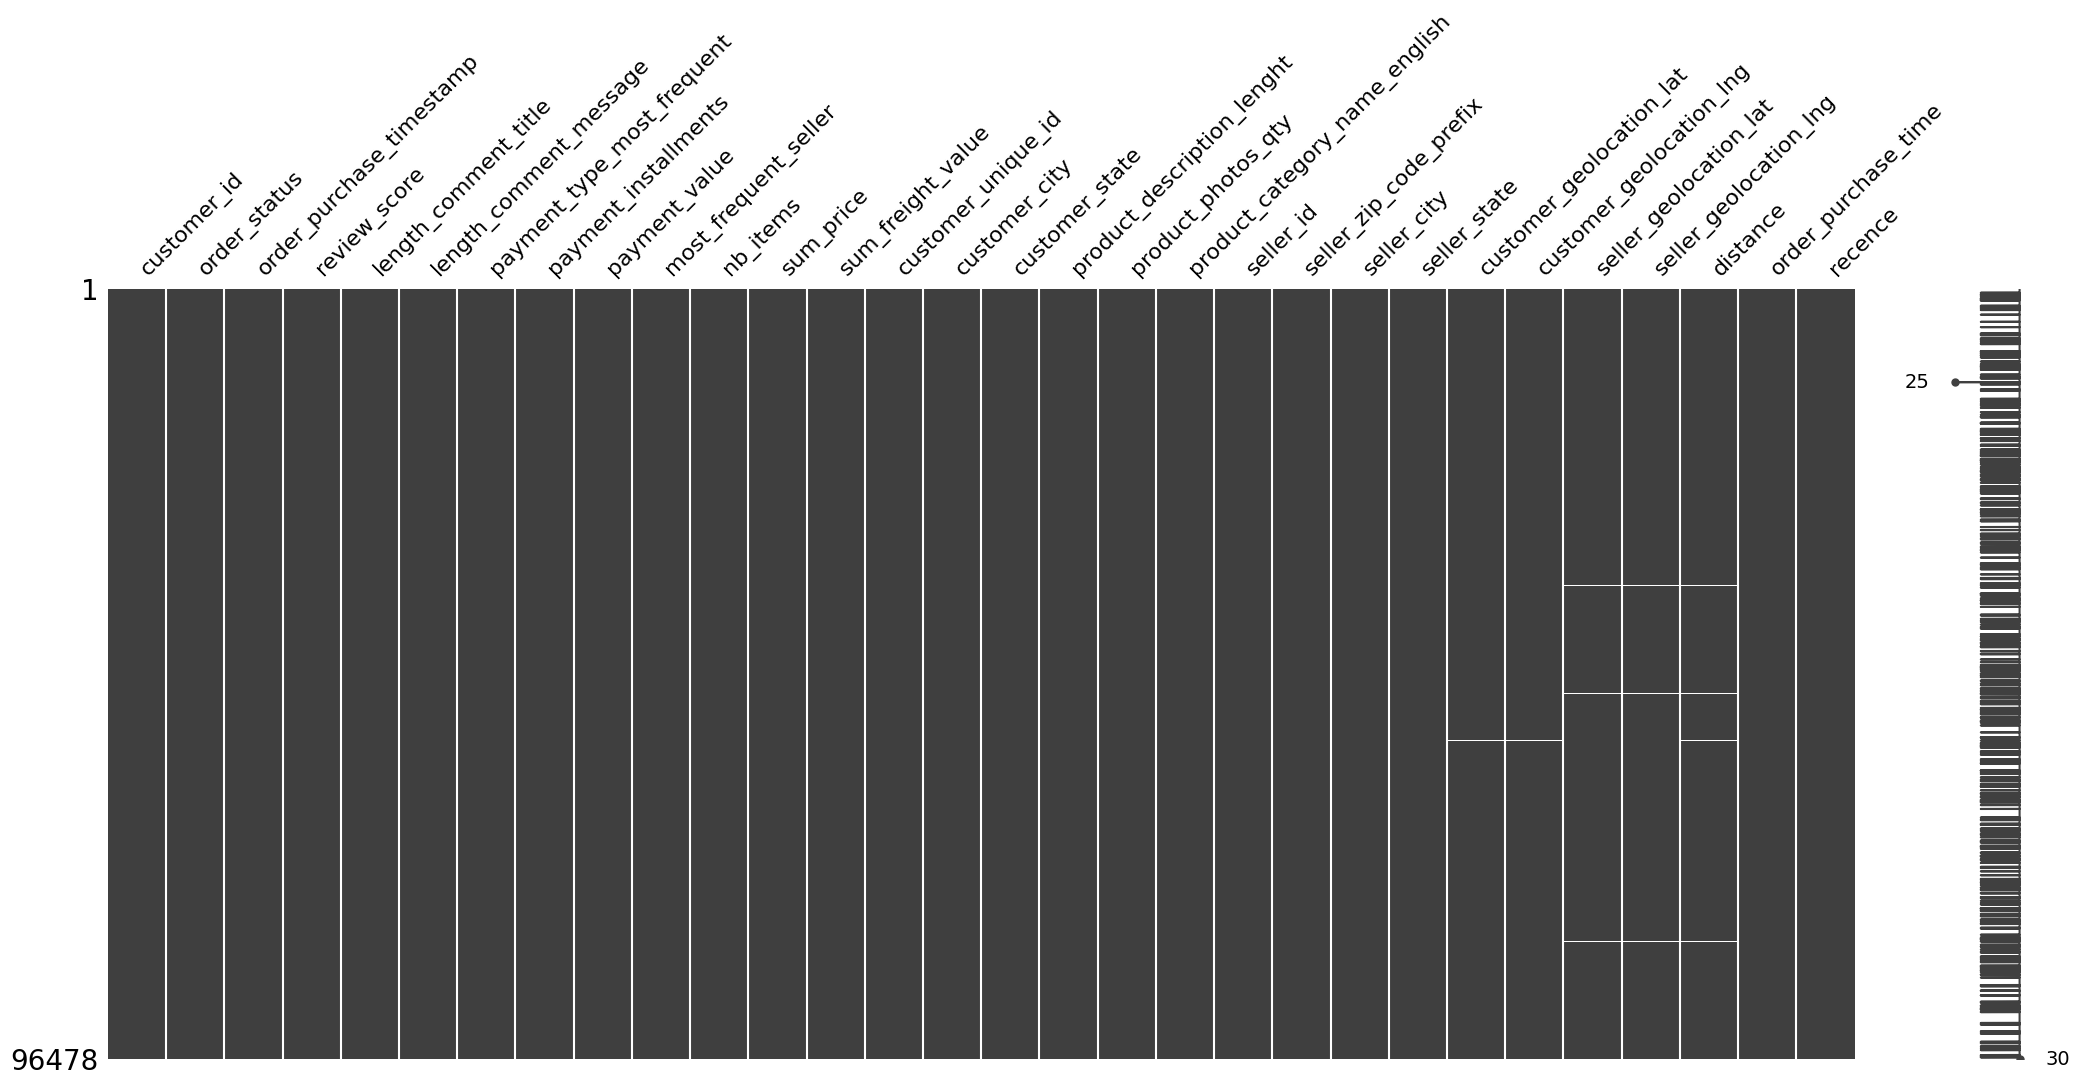

In [132]:
import missingno as msno

msno.matrix(df_merge)

In [133]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 96477
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    96478 non-null  object        
 1   order_status                   96478 non-null  object        
 2   order_purchase_timestamp       96478 non-null  datetime64[ns]
 3   review_score                   96478 non-null  float64       
 4   length_comment_title           96478 non-null  float64       
 5   length_comment_message         96478 non-null  float64       
 6   payment_type_most_frequent     96477 non-null  object        
 7   payment_installments           96477 non-null  float64       
 8   payment_value                  96477 non-null  float64       
 9   most_frequent_seller           96478 non-null  object        
 10  nb_items                       96478 non-null  float64       
 11  sum_price      

In [134]:
df_merge[df_merge["payment_type_most_frequent"].isnull()]

,customer_id,order_status,order_purchase_timestamp,review_score,length_comment_title,length_comment_message,payment_type_most_frequent,payment_installments,payment_value,most_frequent_seller,nb_items,sum_price,sum_freight_value,customer_unique_id,customer_city,customer_state,product_description_lenght,product_photos_qty,product_category_name_english,seller_id,seller_zip_code_prefix,seller_city,seller_state,customer_geolocation_lat,customer_geolocation_lng,seller_geolocation_lat,seller_geolocation_lng,distance,order_purchase_time,recence
31235,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,1.0,0.0,46.0,NaN,NaN,NaN,ecccfa2bb93b34a3bf033cc5d1dcdc69,3.0,134.97,8.49,830d5b7aaa3b6f1e9ad63703bec97d23,sao joaquim da barra,SP,1036.0,1.0,health_beauty,ecccfa2bb93b34a3bf033cc5d1dcdc69,81810,curitiba,PR,-20.585396,-47.863156,-25.507138,-49.276529,5.120661,09/15/2016,767.0


In [135]:
df_merge.dropna(inplace=True)

In [136]:
list_sum = ["nb_items","payment_value"]
list_count =["customer_id"]
list_mod = ["payment_type_most_frequent","product_category_name_english"]
list_mean = ["review_score","payment_installments","length_comment_title","length_comment_message","distance"]
list_first = ["recence"]
list_median = ["product_photos_qty","product_description_lenght"]

dict_sum = dict.fromkeys(list_sum,"sum")
dict__count = dict.fromkeys(list_count,"count")
dict_mod = dict.fromkeys(list_mod,get_mode)
dict_mean = dict.fromkeys(list_mean,"mean")
dict_first = dict.fromkeys(list_first,"first")
dict_median =dict.fromkeys(list_median,np.median)

dict_agg = {**dict_sum ,**dict__count,**dict_mod,**dict_mean,**dict_first,**dict_median}

In [137]:
df_final = df_merge.groupby("customer_unique_id").agg(dict_agg)

In [138]:
df_final.columns 

Index(['nb_items', 'payment_value', 'customer_id',
       'payment_type_most_frequent', 'product_category_name_english',
       'review_score', 'payment_installments', 'length_comment_title',
       'length_comment_message', 'distance', 'recence', 'product_photos_qty',
       'product_description_lenght'],
      dtype='object')

In [139]:
df_final.columns = ["nb_items_total","montant_total","nb_commande","payment_type_most_frequent","most_frequent_product_category","mean_review_score","mean_payment_installments","mean_length_comment_title","mean_length_comment_message","mean_distance","recence","med_product_photos_qty","med_product_description_lenght"]

In [140]:
df_final

,nb_items_total,montant_total,nb_commande,payment_type_most_frequent,most_frequent_product_category,mean_review_score,mean_payment_installments,mean_length_comment_title,mean_length_comment_message,mean_distance,recence,med_product_photos_qty,med_product_description_lenght
customer_unique_id,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1.0,141.90,1,credit_card,bed_bath_table,5.0,8.0,15.0,111.0,1.047809,165.0,1.0,236.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1.0,27.19,1,credit_card,health_beauty,4.0,1.0,0.0,0.0,0.215858,168.0,1.0,635.0
0000f46a3911fa3c0805444483337064,1.0,86.22,1,credit_card,stationery,3.0,8.0,0.0,0.0,4.718337,591.0,3.0,177.0
0000f6ccb0745a6a4b88665a16c9f078,1.0,43.62,1,credit_card,telephony,4.0,4.0,0.0,12.0,22.323718,375.0,5.0,1741.0
0004aac84e0df4da2b147fca70cf8255,1.0,196.89,1,credit_card,telephony,5.0,6.0,0.0,0.0,1.511395,342.0,3.0,794.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2.0,2067.42,1,credit_card,health_beauty,5.0,10.0,0.0,0.0,18.181014,501.0,1.0,423.0
fffea47cd6d3cc0a88bd621562a9d061,1.0,84.58,1,credit_card,baby,4.0,1.0,0.0,0.0,14.007418,316.0,2.0,506.0
ffff371b4d645b6ecea244b27531430a,1.0,112.46,1,credit_card,auto,5.0,1.0,0.0,0.0,14.092158,622.0,5.0,716.0


In [141]:
df_final.to_csv("data/data_merge.csv",index=False)